# A draft of the image overlap finding pipeline

## Imports and "Inputs definition"

In [1]:

# IMPORTS

import cv2
import numpy as np 
import os
import torch
from types import SimpleNamespace

from frameworks.opencv.homography.homography_matrix import BatchHomographyMatrixEstimator
from frameworks.opencv.homography.homography_matrix import RANSAC_MatrixEstimator, Dense_PointFinder
from frameworks.opencv.homography.overlap import compute_overlap
from frameworks.opencv.homography.translate_mask import translate_mask
from frameworks.pytorch.utils.scales_process import torch_batch_scales_process_numpy
from platges_utils.map_model_utils import platja_list_applier, refine_segmentation, normalized_correlation
from platges_utils.model.pyconvsegnet import build_PyConvSegNet_from_params


# CONSTANTS

INPUTS_ROOT = "/mnt/c/Users/Ignasi/Desktop/cosas/test/"
INPUTS = [f.path for f in os.scandir(INPUTS_ROOT) if f.is_file()]

MODEL_NOVA_ICARIA = "./outputs/map_models/nova_icaria.hdf5"
MODEL_BOGATELL = "./outputs/map_models/bogatell.hdf5"

MAP_MODEL_FILENAME_LIST = [MODEL_NOVA_ICARIA, MODEL_BOGATELL]


READ_FLAG = cv2.IMREAD_COLOR

KERNEL = np.ones((50, 50), np.uint8)


## Dataloading mechanisms

In [2]:

def image_loader(inputs):
    
    for input_ in inputs:

        image = cv2.imread(input_, READ_FLAG) # (#row, #col, #color) (shape = H, W, 3)
        if READ_FLAG == cv2.IMREAD_COLOR : image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        yield input_, image
        

## Preparation for MapModel utilities usage

In [3]:

# TODO: As authomatic point matching is not working well, define manual point matching for the "ensayo" and later study better this part
point_finder = Dense_PointFinder(1000)
descriptor_finder = None
matrix_finder = None

homography_estimator = BatchHomographyMatrixEstimator(point_finder=point_finder, descriptor_finder=descriptor_finder, matrix_finder=matrix_finder)

mask_translator = translate_mask

# compute_overlap(x, v_H) where x is a vector of images and v_H is a vector of homography matrix that transform the images into a common plane
overlap_finder = compute_overlap


## Model matching and Homography overlap

In [4]:

v_overlap = []

v_map_model = []
v_image = []
v_h = []

VERBOSE = True
for image_filename, image in image_loader(INPUTS):
    if VERBOSE : print(image_filename)
    
    semisupervised_mask, h, name, image, map_model_filename = platja_list_applier(image_filename, MAP_MODEL_FILENAME_LIST, homography_estimator, mask_translator, 
            image_mask=None,
            distance_funct=None,
            k_nearest=None,
            max_distance=None,
            undefined_class=0,
            nearness_limit=0,
            read_flag=READ_FLAG
        )
        
    v_map_model.append(map_model_filename)
    v_image.append(image)
    v_h.append(h)
    
    if VERBOSE : print(f'{map_model_filename}\n---')


/mnt/c/Users/Ignasi/Desktop/cosas/test/00_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/01_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/03_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/04_13_58.jpg
./outputs/map_models/nova_icaria.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/05_13_58.jpg
./outputs/map_models/bogatell.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/07_13_58.jpg
./outputs/map_models/bogatell.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/08_13_58.jpg
./outputs/map_models/bogatell.hdf5
---
/mnt/c/Users/Ignasi/Desktop/cosas/test/11_13_58.jpg
./outputs/map_models/bogatell.hdf5
---


In [5]:

v_overlaps = []

VERBOSE = True
for map_model in np.unique(v_map_model):
    
    if VERBOSE : print(f'Starting {map_model}')
    
    near_images, images_matrix = list(zip(*[(x, y) for x, y, z in zip(v_image, v_h, v_map_model) if z == map_model]))
    
    paired_overlaps = overlap_finder(near_images, images_matrix)
    
    v_overlaps.append(paired_overlaps)
    
    if VERBOSE : print(f'Done {map_model}\n---')


Starting ./outputs/map_models/bogatell.hdf5
Done ./outputs/map_models/bogatell.hdf5
---
Starting ./outputs/map_models/nova_icaria.hdf5
Done ./outputs/map_models/nova_icaria.hdf5
---


## Visualization

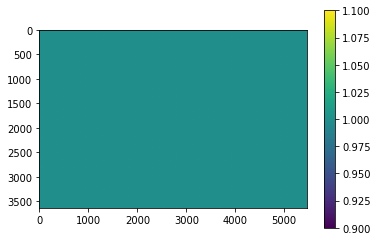

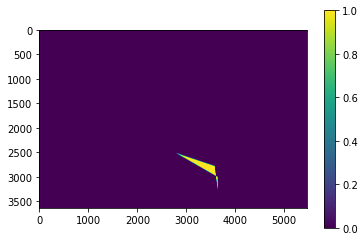

In [7]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.imshow(v_overlaps[0][0, 0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(v_overlaps[0][1, 2], vmin=0, vmax=1)
plt.colorbar()
plt.show()